## DL 大阪2期　中間報告  
### 河野 哲大
---
---



### 1.最急降下法を用いたNN(さまざまな降下法を習う前)
--

#### ※誤作動でコードが紛失
#### Batch正則化:B  荷重減衰:W ドロップアウト:D 

|---|Simple|W|B,W|W,D|B,D,W|
|---|---|---|---|---|---|
|中間層1つ|① 90.83|③ 90.17|⑤ 90.33|⑦ 89.67|⑨ 89.50|
|中間層2つ|② 92.17|④ 91.00|⑥ 90.33|⑧ 91.17|⑩ 90.50|


| --- | B-size | Learn | node1 | node2 |
|---|---|---|---|---|
|①|20|0.1|800|---|
|②|20|0.1|1000|800|
|③|40|0.1|100|---|
|④|40|0.1|300|400|
|⑤|25|0.1|800|---|
|⑥|10|0.1|600|900|
|⑦|10|0.01|100|---|
|⑧|60|0.01|600|600|
|⑨|10|0.1|100|---|
|⑩|10|0.01|600|100|

---
---

### 2.さまざまな降下法を用いたNN
---

#### あるサイトを参考にし、RMSpropを選びました。(時間がなく、様々な降下法で最適化できませんでした、、、、)


#### ・参考にしたサイト
https://www.iandprogram.net/entry/2016/02/11/181322
#### RMSprop > Momentum > Adadelta > ・・・
#### ↑ mnistデータを用いたCNNでの文字認識。今回はCNNを用いていないが、参考にさせてもらいました。


#### 学習率0.0005 バッチサイズ256 中間ノード数128 (中間層1層)
|---|test_loss|test_accuracy|
|---|---|---|
|---|0.806|93.0|

### 3.Batch正則化 or Dropout層 
---


#### (dropout)　学習率0.001 バッチサイズ256 中間ノード数128 (中間層1層)

#### (Batch正則化)　間に合いませんでした、、、


|---|test_loss|test_accuracy|
|---|---|---|
|Batch正則化|---|---|
|Dropout|2.56|91.0|
#### 大きくは変わらず、、、


#### もともと過学習や誤差について最適化しながら、モデルを構築しているので、そもそもBatch正則化やDropoutを用いる必要がないのかもしれない。

### 4.興味本位でCNNを用いてみる
---
#### 高精度が出ると言われるCNNを用いて、どのくらいの精度を叩き出せるのか確認してみた。

|---|test_loss|test_accuracy|
|---|---|---|
|---|0.401|95.0|

#### 最高精度は98.0を示しており、また誤差も他のモデルと比べて0.40と低い。
#### しかし、CNNでさえも安定して97以上の精度が出ないということは、やはりデータ量の少なさが要因ではないかと推測。



### 5.データ量を多くするには....
---

#### 訓練データが少ないので、少ないトレーニングデータでも対応できるようなモデルにしなければならない。

#### 今後はCNNに近づくようなモデルを作るために、[水増し]と呼ばれる方法があるようだ。

#### ・縮小、拡大
#### ・文字をずらす

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
data = np.load(r"C:\Users\Akihiro\Desktop\dl\assignment\data\train_data.npy")# とりあえずデータをロードする
label = np.load(r"C:\Users\Akihiro\Desktop\dl\assignment\data\train_label.npy")
data = (data - data.min()) / data.max()# データを正規化する
data = data.astype('float32')
test = data[0:100,:,:,:].copy()
train = data[100:3000,:,:,:].copy()# すべてのデータをtest(20%) , train(80%)に分ける
t_test = label[0:100,:]# すべてのラベルデータをtest(20%) , train(80%)に分ける
t_train = label[100:3000,:]
x_train = train.reshape(2900,784)
x_test = test.reshape(100,784)

In [2]:
class TwoLayerNet_RMSProp:
    def __init__(self, input_size,lr, hidden_size,output_size, weight_init_std = 0.01,weight_decay_lambda=0.01):
        self.hidden_layer_num = 1
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        self.layers = OrderedDict() # 順番付きdict形式. ただし、Python3.6以降は、普通のdictでもよい
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss() # 出力層        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x
    def loss(self, x, t):
        y = self.predict(x)             
        return self.lastLayer.forward(y, t)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)        
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1 # クロスエントロピー誤差を用いる場合は使用されない
        dout = self.lastLayer.backward(dout=1) # 出力層
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        lmd = self.weight_decay_lambda
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + lmd * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
        return grads
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

In [3]:
import numpy as np
from collections import OrderedDict
import numpy as np

def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

import numpy as np

def numerical_gradient(f, W):
    """
    全ての次元について、個々の次元だけの微分を求める
    f : 関数
    W : 偏微分を求めたい場所の座標。多次元配列
    """
    h = 1e-4 # 0.0001
    grad = np.zeros_like(W)
    
    it = np.nditer(W, flags=['multi_index'])
    
    while not it.finished:
        idx = it.multi_index
        tmp_val = W[idx]
        
        W[idx] = tmp_val + h
        fxh1 = f(W)
        
        W[idx] = tmp_val - h 
        fxh2 = f(W)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        W[idx] = tmp_val # 値を元に戻す
        
        # 次のindexへ進める
        it.iternext()   
        
    return grad

def cross_entropy_error(y, t):
    """
    y : 出力値(通常は、0-1の確率)  
    t : 正解値(通常は、0or1)  
    """
    if y.ndim==1:
        t = t.reshape(1, -1)
        y = y.reshape(1, -1)
        
    batch_size = y.shape[0]
    delta = 1e-7
    return -np.sum( t * np.log(y + delta)) / batch_size

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy() #参照渡しではなく複製する
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        """
        dout : float, 上流(出力)側の勾配
        """        
        dout[self.mask] = 0
        dLdx = dout
        return dLdx
    
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        # 初期値
        self.x = None
        self.original_x_shape = None
        self.dW = None # 重みの微分
        self.db = None # バイアスの微分

    def forward(self, x):
        """
        順伝播
        """
        # 値の保持
        self.x = x

        # 順伝播
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        """
        逆伝播
        dout : float, 上流(出力)側の勾配
        """
        # dxは前の層に伝える必要がある
        dx = np.dot(dout, self.W.T)
        
        # dWとdbは、勾配法の計算に使われるので、値を保持しておく
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0) # N個の合計になる
        
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        
        # 初期値
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        """
        順伝播
        """
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        """
        逆伝播
        伝播する値をバッチサイズで割ること
        """
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.001):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict() # 順番付きdict形式. ただし、Python3.6以降は、普通のdictでもよい
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss() # 出力層
        
    def predict(self, x):
        """
        推論関数
        x : 入力
        """
        for layer in self.layers.values():
            # 入力されたxを更新していく = 順伝播計算
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        """
        損失関数
        x:入力データ, t:教師データ
        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        """
        識別精度
        """
        # 推論. 返り値は正規化されていない実数
        y = self.predict(x)
        #正規化されていない実数をもとに、最大値になるindexに変換する
        y = np.argmax(y, axis=1)
        
        if t.ndim != 1 : 
            """
            one-hotベクトルの場合、教師データをindexに変換する
            """
            t = np.argmax(t, axis=1)
        
        # 精度
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        """
        全パラメータの勾配を計算
        """
        
        # 順伝播
        self.loss(x, t)

        # 逆伝播
        dout = 1 # クロスエントロピー誤差を用いる場合は使用されない
        dout = self.lastLayer.backward(dout=1) # 出力層
        
        ## doutを逆向きに伝える 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # dW, dbをgradsにまとめる
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    

    def numerical_gradient(self, x, t):
        """
        勾配確認用
        x:入力データ, t:教師データ        
        """
        
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

class RMSProp:
    """
    RMSProp
    """
    def __init__(self, lr=0.01, rho=0.9):
        """
        lr : 学習係数 learning rate
        rho : 減衰率
        """
        self.lr = lr
        self.h = None
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + self.epsilon) ) # 原論文に合わせてepsilonをルートの中に入れる




In [24]:
x = x_train
t = t_train

def two_RMSprop(optimizer,batch_size,lr,hidden_size):
    epochs = 200# 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)
    # 2層NNのオブジェクト生成
    twonet = TwoLayerNet_RMSProp(lr = lr,input_size=784, hidden_size=hidden_size, output_size=15,weight_init_std=0.01,weight_decay_lambda=0.001)
    result = []
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        idx = np.arange(xsize)# シャッフル
        np.random.shuffle(idx)
        for it in range(iter_num):#ランダムなミニバッチを順番に取り出す
            mask = idx[batch_size*it : batch_size*(it+1)]
            x_batchtrain = x[mask]# ミニバッチの生成
            t_batchtrain = t[mask]
            grads = twonet.gradient(x_batchtrain, t_batchtrain)# 勾配の計算 (誤差逆伝播法を用いる)
            optimize = optimizer(lr = lr)
            optimize.update(twonet.params, grads)
        # 訓練データにおけるloss
        train_loss.append(twonet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(twonet.loss(x_test,t_test))

        # 訓練データにて精度を確認
        train_accuracy.append(twonet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(twonet.accuracy(x_test, t_test))
        
    # lossのグラフ化
    df_log = pd.DataFrame({"train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    
    result_accuracy = np.array(test_accuracy)    
    #print(result_accuracy.max(axis=0))
    
    result_loss = np.array(test_loss)    
    #print(result_loss.max(axis=0))
    final=[]
    final.append(result_accuracy.max(axis=0))
    final.append(result_loss.mean(axis=0))
    final = pd.DataFrame(final,index=("test_accuracy","test_loss"))
    display(final)

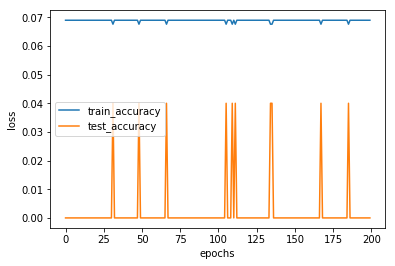

,0
test_accuracy,0.040000
test_loss,2.846243


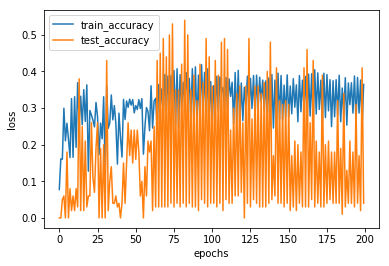

,0
test_accuracy,0.540000
test_loss,5.928722


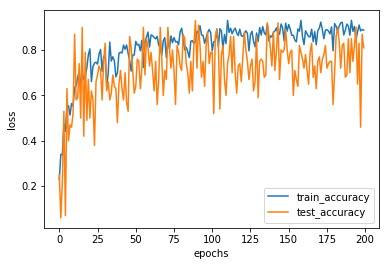

,0
test_accuracy,0.930000
test_loss,1.675475


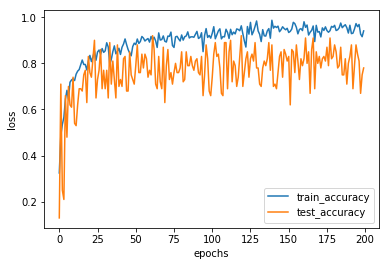

,0
test_accuracy,0.920000
test_loss,1.055393


In [25]:
# ひとまず学習率から最適化
#two_RMSprop(optimizer,batch_size,lr,hidden_size):
for i in [0.01,0.005,0.001,0.0005]:
    two_RMSprop(RMSProp,128,i,128)
    
# →0.001

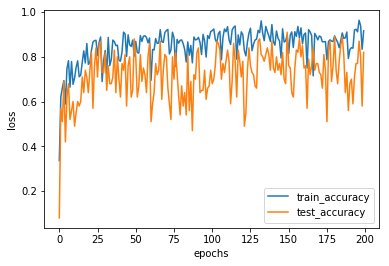

,0
test_accuracy,0.910000
test_loss,1.638787


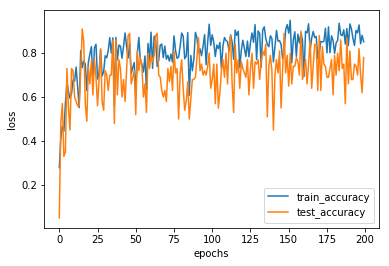

,0
test_accuracy,0.910000
test_loss,2.163034


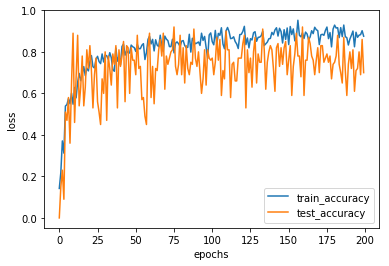

,0
test_accuracy,0.920000
test_loss,1.643661


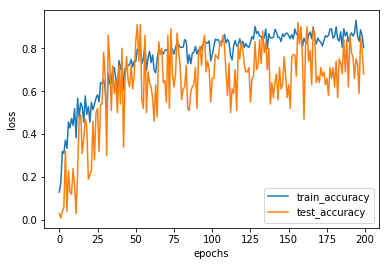

,0
test_accuracy,0.9200
test_loss,1.7625


In [26]:
# 学習率0.001固定でバッチサイズを変数に
#two_RMSprop(optimizer,batch_size,lr,hidden_size):
for i in [32,64,128,256]:
    two_RMSprop(RMSProp,i,0.001,128)

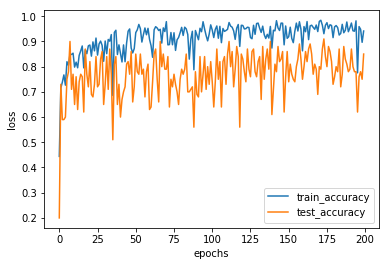

,0
test_accuracy,0.910000
test_loss,1.139129


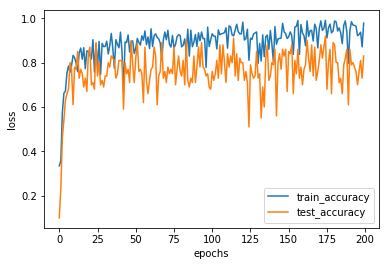

,0
test_accuracy,0.920000
test_loss,1.298013


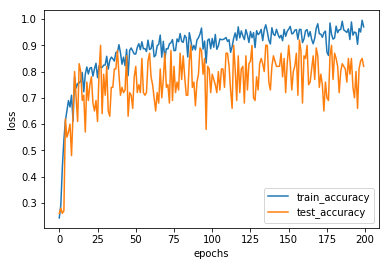

,0
test_accuracy,0.920000
test_loss,1.071381


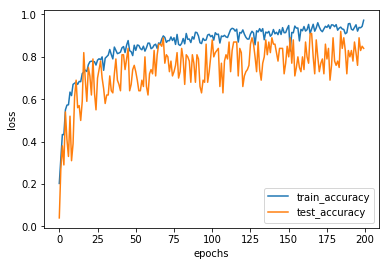

,0
test_accuracy,0.920000
test_loss,0.958557


In [27]:
# 学習率0.0005固定でバッチサイズを変数に
#two_RMSprop(optimizer,batch_size,lr,hidden_size):
for i in [32,64,128,256]:
    two_RMSprop(RMSProp,i,0.0005,128)
    
    
# 学習率を0.0005にすると過学習の傾向にある

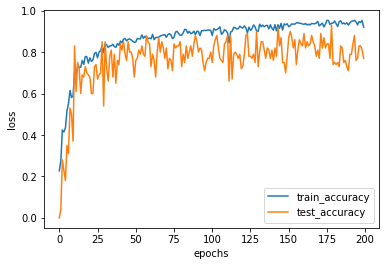

,0
test_accuracy,0.930000
test_loss,0.806086


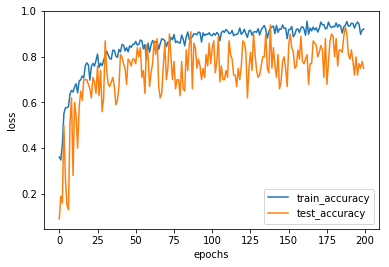

,0
test_accuracy,0.940000
test_loss,0.904773


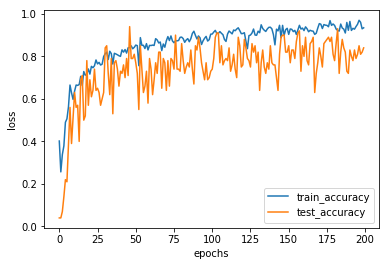

,0
test_accuracy,0.940000
test_loss,0.951437


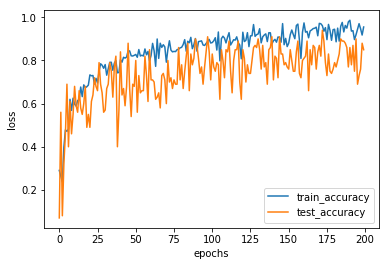

,0
test_accuracy,0.940000
test_loss,1.111269


In [28]:
# 学習率0.001固定でバッチサイズ128固定、中間層のノード数を変数
#two_RMSprop(optimizer,batch_size,lr,hidden_size):
for i in [32,64,128,256]:
    two_RMSprop(RMSProp,256,0.0005,i)
    
# 中間層を32にするのがよさそうだが、若干過学習の傾向にある。

In [38]:
class BatchNormalization:
    def __init__(self, gamma, beta, rho=0.9, moving_mean=None, moving_var=None,dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.gamma = gamma # スケールさせるためのパラメータ, 学習によって更新させる.
        self.beta = beta # シフトさせるためのパラメータ, 学習によって更新させる
        self.rho = rho # 移動平均を算出する際に使用する減衰率
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  
        self.moving_mean = moving_mean # muの移動平均
        self.moving_var = moving_var        # varの移動平均
        self.batch_size = None
        self.x_mu = None
        self.x_std = None        
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        x = x* (1.0 - self.dropout_ratio)
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)
        out = self.__forward(x, train_flg)
        out = out.reshape(self.input_shape)# 元の配列形式に戻す
        return out
    def __forward(self, x, train_flg, epsilon=1e-8):
        x = x *(1.0 - self.dropout_ratio)
        if (self.moving_mean is None) or (self.moving_var is None):
            N, D = x.shape
            self.moving_mean = np.zeros(D)
            self.moving_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0) # 要素数d個のベクトル
            x_mu = x - mu   # n*d行列
            var = np.mean(x_mu**2, axis=0)  # 要素数d個のベクトル
            std = np.sqrt(var + epsilon)  # 要素数d個のベクトル
            x_std = x_mu / std  # n*d行列
            self.batch_size = x.shape[0]
            self.x_mu = x_mu
            self.x_std = x_std
            self.std = std
            self.moving_mean = self.rho * self.moving_mean + (1-self.rho) * mu
            self.moving_var = self.rho * self.moving_var + (1-self.rho) * var            
        else:
            x_mu = x - self.moving_mean # n*d行列
            x_std = x_mu / np.sqrt(self.moving_var + epsilon) # n*d行列
        

        out = self.gamma * x_std + self.beta # n*d行列
        return out

    def backward(self, dout):
        if dout.ndim != 2:          
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
        dx = self.__backward(dout)
        dx = dx.reshape(self.input_shape)# 元の配列形式に戻す
        return dx
    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.x_std * dout, axis=0)
        a1 = self.gamma * dout
        a2 = a1 / self.std
        a3 = a1 * self.x_mu 
        a4 = -(np.sum(a3, axis=0) ) / (self.std * self.std)
        a5 = 0.5 * a4 / self.std
        a6 = a5 / self.batch_size
        a7 = 2.0  * self.x_mu * a6
        a8 = -(a2+a7)
        dx = a2 + a7 +  np.sum(a8, axis=0) / self.batch_size
        self.dgamma = dgamma
        self.dbeta = dbeta
        return dx

In [39]:
class TwoLayerNet_Batch_norm:
    def __init__(self, input_size,lr, hidden_size,output_size, weight_init_std = 0.01,weight_decay_lambda=0.01,use_batchnorm=True):
        self.mask = None
        self.hidden_layer_num = 1
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        self.layers = OrderedDict() # 順番付きdict形式. ただし、Python3.6以降は、普通のdictでもよい
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.params['gamma1'] = np.ones(hidden_size)
        self.params['beta1'] = np.zeros(hidden_size)
        self.layers['BatchNorm1'] = BatchNormalization(self.params['gamma1'], self.params['beta1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss() # 出力層
 
    def __init_weight(self, weight_init_std):
        scale = weight_init_std   
        scale = np.sqrt(2.0 / self.input_size)  # ReLUを使う場合に推奨される初期値
        self.params['W1'] = scale * np.random.randn(self.input_size, self.hidden_size)
        self.params['b1'] = np.zeros(self.hidden_size)
        scale = weight_init_std        
        scale = np.sqrt(2.0 / self.hidden_size)  # ReLUを使う場合に推奨される初期値
        self.params['W2'] = scale * np.random.randn(self.hidden_size, self.output_size)
        self.params['b2'] = np.zeros(self.output_size)
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        lmd = self.weight_decay_lambda        
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * lmd * np.sum(W**2)
        return self.lastLayer.forward(y, t) + weight_decay
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1 # クロスエントロピー誤差を用いる場合は使用されない
        dout = self.lastLayer.backward(dout=1) # 出力層
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        lmd = self.weight_decay_lambda
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta
        return grads
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t,train_flg=True)
        print(loss_W)
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['gamma1'] = numerical_gradient(loss_W, self.params['gamma1'])
        grads['beta1'] = numerical_gradient(loss_W, self.params['beta1'])
        return grads

In [40]:
x = x_train
t = t_train

def two_RMSprop_batchnorm(optimizer,batch_size,lr,hidden_size):
    epochs = 200# 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)
    # 2層NNのオブジェクト生成
    twonet = TwoLayerNet_Batch_norm(lr = lr,input_size=784, hidden_size=hidden_size, output_size=15,weight_init_std=0.01)
    result = []
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        idx = np.arange(xsize)# シャッフル
        np.random.shuffle(idx)
        for it in range(iter_num):#ランダムなミニバッチを順番に取り出す
            mask = idx[batch_size*it : batch_size*(it+1)]
            x_batchtrain = x[mask]# ミニバッチの生成
            t_batchtrain = t[mask]
            grads = twonet.gradient(x_batchtrain, t_batchtrain)# 勾配の計算 (誤差逆伝播法を用いる)
            optimize = optimizer(lr = lr)
            optimize.update(twonet.params, grads)
        # 訓練データにおけるloss
        train_loss.append(twonet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(twonet.loss(x_test,t_test))

        # 訓練データにて精度を確認
        train_accuracy.append(twonet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(twonet.accuracy(x_test, t_test))
        
    # lossのグラフ化
    df_log = pd.DataFrame({"train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    
    result_accuracy = np.array(test_accuracy)    
    #print(result_accuracy.max(axis=0))
    
    result_loss = np.array(test_loss)    
    #print(result_loss.max(axis=0))
    final=[]
    final.append(result_accuracy.max(axis=0))
    final.append(result_loss.mean(axis=0))
    final = pd.DataFrame(final,index=("test_accuracy","test_loss"))
    display(final)

In [29]:
class ReLU_withdrop:
    def __init__(self,dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    def forward(self, x):
        x = x *(1.0 - self.dropout_ratio)
        self.mask = (x <= 0)
        out = x.copy() #参照渡しではなく複製する
        out[self.mask] = 0
        return out
    def backward(self, dout):       
        dout[self.mask] = 0
        dLdx = dout
        return dLdx  
class Affine_withdrop:
    def __init__(self, W, b,dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.W =W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None # 重みの微分
        self.db = None # バイアスの微分2
    def forward(self, x):
        self.x = x * (1.0 - self.dropout_ratio)
        out = np.dot(self.x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0) # N個の合計になる
        return dx

In [30]:
class TwoLayerNet_dropout:
    def __init__(self, input_size, hidden_size,lr, output_size,weight_init_std = 0.01,weight_decay_lambda=0.01):
        # 重みの初期化
        self.hidden_layer_num = 1
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        self.layers = OrderedDict() # 順番付きdict形式. ただし、Python3.6以降は、普通のdictでもよい
        self.layers['Affine1'] = Affine_withdrop(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU_withdrop()
        self.layers['Affine2'] = Affine_withdrop(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss() # 出力層
    def predict(self, x):#推論関数 x : 入力   入力されたxを更新していく = 順伝播計算
        for layer in self.layers.values():
            x = layer.forward(x)
        return x  
    def loss(self, x, t):#損失関数  x:入力データ, t:教師データ
        y = self.predict(x)
        lmd = self.weight_decay_lambda # 荷重減衰を考慮した損失を求める       
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]       
            weight_decay += 0.5 * lmd * np.sum(W**2)# 全ての行列Wについて、1/2* lambda * Σwij^2を求め、積算していく
        return self.lastLayer.forward(y, t) + weight_decay
    def accuracy(self, x, t):#識別精度
        y = self.predict(x)# 推論. 返り値は正規化されていない実数   
        y = np.argmax(y, axis=1)#正規化されていない実数をもとに、最大値になるindexに変換する
        if t.ndim != 1 : #one-hotベクトルの場合、教師データをindexに変換する
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])# 精度
        return accuracy  
    def gradient(self, x, t):#全パラメータの勾配を計算  
        self.loss(x, t)# 順伝播
        dout = 1 # 逆伝播# クロスエントロピー誤差を用いる場合は使用されない
        dout = self.lastLayer.backward(dout=1) # 出力層    
        layers = list(self.layers.values())## doutを逆向きに伝える
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        lmd = self.weight_decay_lambda# 荷重減衰を考慮しながら、dW, dbをgradsにまとめる
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + lmd * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db   
        return grads
    def numerical_gradient(self, x, t):#勾配確認用x:入力データ, t:教師データ
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

In [31]:
x = x_train
t = t_train

def two_RMSprop_dropout(optimizer,batch_size,lr,hidden_size):
    epochs = 200# 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)
    # 2層NNのオブジェクト生成
    twonet = TwoLayerNet_dropout(lr = lr,input_size=784, hidden_size=hidden_size, output_size=15,weight_init_std=0.01)
    result = []
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        idx = np.arange(xsize)# シャッフル
        np.random.shuffle(idx)
        for it in range(iter_num):#ランダムなミニバッチを順番に取り出す
            mask = idx[batch_size*it : batch_size*(it+1)]
            x_batchtrain = x[mask]# ミニバッチの生成
            t_batchtrain = t[mask]
            grads = twonet.gradient(x_batchtrain, t_batchtrain)# 勾配の計算 (誤差逆伝播法を用いる)
            optimize = optimizer(lr = lr)
            optimize.update(twonet.params, grads)
        # 訓練データにおけるloss
        train_loss.append(twonet.loss(x,  t))

        # テストデータにおけるloss
        test_loss.append(twonet.loss(x_test,t_test))

        # 訓練データにて精度を確認
        train_accuracy.append(twonet.accuracy(x, t))

        # テストデータにて精度を算出
        test_accuracy.append(twonet.accuracy(x_test, t_test))
        
    # lossのグラフ化
    df_log = pd.DataFrame({"train_accuracy":train_accuracy,
                 "test_accuracy":test_accuracy})
    df_log.plot()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    
    result_accuracy = np.array(test_accuracy)    
    #print(result_accuracy.max(axis=0))
    
    result_loss = np.array(test_loss)    
    #print(result_loss.max(axis=0))
    final=[]
    final.append(result_accuracy.max(axis=0))
    final.append(result_loss.mean(axis=0))
    final = pd.DataFrame(final,index=("test_accuracy","test_loss"))
    display(final)

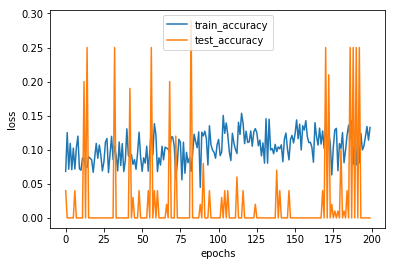

,0
test_accuracy,0.290000
test_loss,2.994601


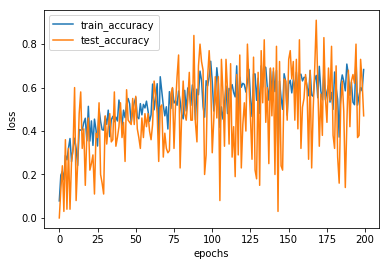

,0
test_accuracy,0.910000
test_loss,19.345787


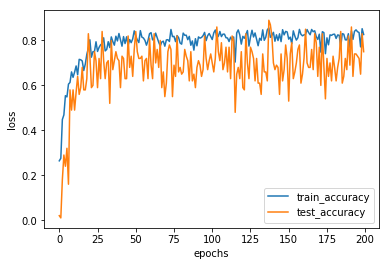

,0
test_accuracy,0.890000
test_loss,2.604052


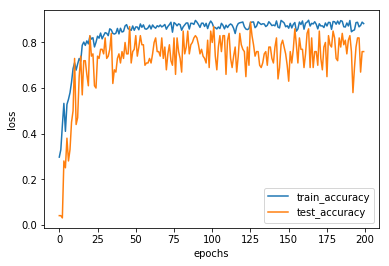

,0
test_accuracy,0.890000
test_loss,2.352925


In [32]:
#two_RMSprop_dropout(optimizer,batch_size,lr,hidden_size):
for i in [0.01,0.005,0.001,0.0005]:
    two_RMSprop_dropout(RMSProp,128,i,128)

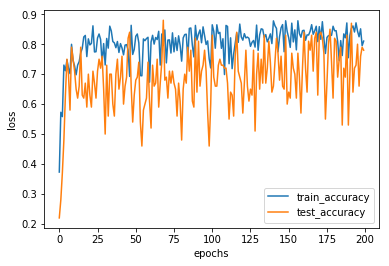

,0
test_accuracy,0.880000
test_loss,2.647436


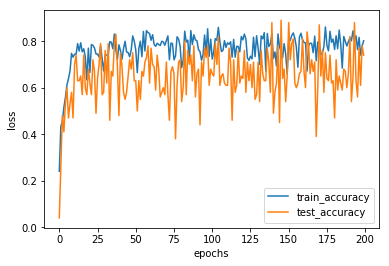

,0
test_accuracy,0.890000
test_loss,2.692171


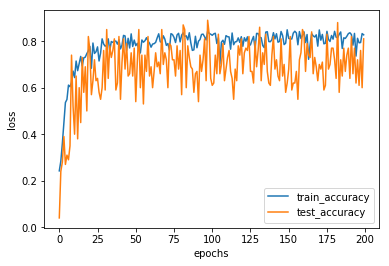

,0
test_accuracy,0.890000
test_loss,2.637994


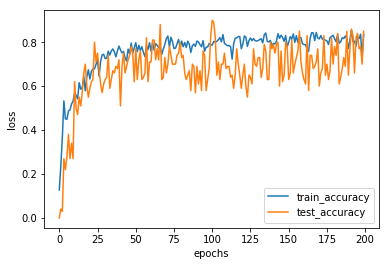

,0
test_accuracy,0.900000
test_loss,2.501674


In [22]:
#two_RMSprop_dropout(optimizer,batch_size,lr,hidden_size):
for i in [32,64,128,256]:
    two_RMSprop_dropout(RMSProp,i,0.001,128)

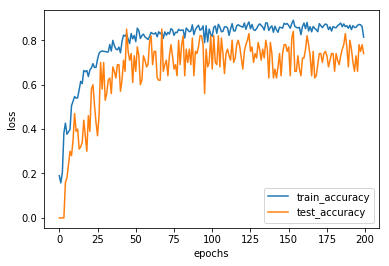

,0
test_accuracy,0.850000
test_loss,2.379082


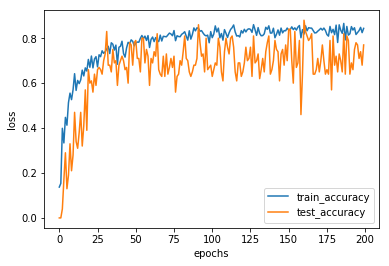

,0
test_accuracy,0.880000
test_loss,2.388622


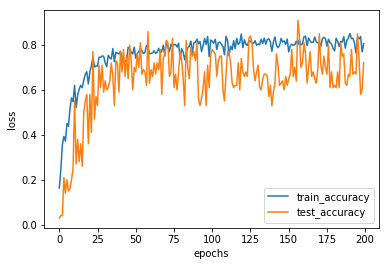

,0
test_accuracy,0.910000
test_loss,2.536074


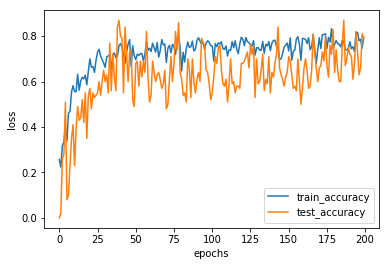

,0
test_accuracy,0.870000
test_loss,2.801184


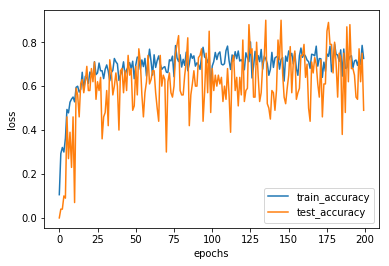

,0
test_accuracy,0.900000
test_loss,3.140878


In [23]:
#two_RMSprop_dropout(optimizer,batch_size,lr,hidden_size):
for i in [32,64,128,256,512]:
    two_RMSprop_dropout(RMSProp,256,0.001,i)

Train on 2900 samples, validate on 100 samples
Epoch 1/1000
2900/2900 [==============================] - 20s 7ms/step - loss: 0.5870 - acc: 0.8390 - val_loss: 0.5373 - val_acc: 0.8500
Epoch 2/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.1656 - acc: 0.9576 - val_loss: 0.5273 - val_acc: 0.8400
Epoch 3/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.0785 - acc: 0.9800 - val_loss: 0.8103 - val_acc: 0.7500
Epoch 4/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.0431 - acc: 0.9900 - val_loss: 0.6748 - val_acc: 0.8100
Epoch 5/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.0278 - acc: 0.9928 - val_loss: 0.2919 - val_acc: 0.9300
Epoch 6/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.0191 - acc: 0.9952 - val_loss: 0.2722 - val_acc: 0.9500
Epoch 7/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 0.0123 - acc: 0.9972 - val_loss: 0.1695 - val_acc: 0

2900/2900 [==============================] - 18s 6ms/step - loss: 1.1362e-05 - acc: 1.0000 - val_loss: 0.2767 - val_acc: 0.9600
Epoch 60/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 7.6916e-04 - acc: 0.9997 - val_loss: 0.4777 - val_acc: 0.9300
Epoch 61/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 8.2046e-06 - acc: 1.0000 - val_loss: 0.2594 - val_acc: 0.9700
Epoch 62/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 8.2237e-06 - acc: 1.0000 - val_loss: 0.2089 - val_acc: 0.9700
Epoch 63/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 8.1178e-05 - acc: 1.0000 - val_loss: 0.3573 - val_acc: 0.9400
Epoch 64/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 4.6777e-04 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9400
Epoch 65/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 8.5828e-06 - acc: 1.0000 - val_loss: 0.4193 - val_acc: 0.9500
Epoch 66/1000
2900/2

2900/2900 [==============================] - 17s 6ms/step - loss: 1.0296e-06 - acc: 1.0000 - val_loss: 0.3629 - val_acc: 0.9300
Epoch 117/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 2.2938e-07 - acc: 1.0000 - val_loss: 0.3363 - val_acc: 0.9500
Epoch 118/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 3.0403e-07 - acc: 1.0000 - val_loss: 0.4597 - val_acc: 0.9300
Epoch 119/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 6.5825e-06 - acc: 1.0000 - val_loss: 0.3714 - val_acc: 0.9700
Epoch 120/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 3.0118e-06 - acc: 1.0000 - val_loss: 0.3480 - val_acc: 0.9500
Epoch 121/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 2.1838e-07 - acc: 1.0000 - val_loss: 0.4775 - val_acc: 0.9700
Epoch 122/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.0887e-06 - acc: 1.0000 - val_loss: 0.2810 - val_acc: 0.9800
Epoch 123/1000

2900/2900 [==============================] - 18s 6ms/step - loss: 1.3758e-07 - acc: 1.0000 - val_loss: 0.3231 - val_acc: 0.9700
Epoch 174/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.3403e-07 - acc: 1.0000 - val_loss: 0.3002 - val_acc: 0.9700
Epoch 175/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.8262e-07 - acc: 1.0000 - val_loss: 0.5602 - val_acc: 0.9500
Epoch 176/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.4607e-07 - acc: 1.0000 - val_loss: 0.4935 - val_acc: 0.9600
Epoch 177/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.8525e-07 - acc: 1.0000 - val_loss: 0.5293 - val_acc: 0.9500e-07 - acc: 1
Epoch 178/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 3.1476e-07 - acc: 1.0000 - val_loss: 0.2730 - val_acc: 0.9700
Epoch 179/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 2.1714e-07 - acc: 1.0000 - val_loss: 0.3513 - val_acc: 0.9600
E

2900/2900 [==============================] - 18s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.9500
Epoch 231/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.4684 - val_acc: 0.9500
Epoch 232/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2024e-07 - acc: 1.0000 - val_loss: 0.4190 - val_acc: 0.9600
Epoch 233/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.5052 - val_acc: 0.9600
Epoch 234/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.2159e-07 - acc: 1.0000 - val_loss: 0.4650 - val_acc: 0.9600
Epoch 235/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2034e-07 - acc: 1.0000 - val_loss: 0.4693 - val_acc: 0.9600
Epoch 236/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1950e-07 - acc: 1.0000 - val_loss: 0.4378 - val_acc: 0.9600
Epoch 237/1000

2900/2900 [==============================] - 17s 6ms/step - loss: 1.1946e-07 - acc: 1.0000 - val_loss: 0.4901 - val_acc: 0.9600
Epoch 288/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.5415e-07 - acc: 1.0000 - val_loss: 0.5920 - val_acc: 0.9600
Epoch 289/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.5147 - val_acc: 0.9600
Epoch 290/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2046e-07 - acc: 1.0000 - val_loss: 0.4500 - val_acc: 0.9600
Epoch 291/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.1972e-07 - acc: 1.0000 - val_loss: 0.4415 - val_acc: 0.9600
Epoch 292/1000
2900/2900 [==============================] - 19s 7ms/step - loss: 1.2223e-07 - acc: 1.0000 - val_loss: 0.4841 - val_acc: 0.9600
Epoch 293/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.4007e-07 - acc: 1.0000 - val_loss: 0.4612 - val_acc: 0.9600
Epoch 294/1000

2900/2900 [==============================] - 17s 6ms/step - loss: 4.7826e-07 - acc: 1.0000 - val_loss: 0.3179 - val_acc: 0.9500
Epoch 345/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.3450 - val_acc: 0.9500
Epoch 346/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.2120e-07 - acc: 1.0000 - val_loss: 0.4154 - val_acc: 0.9400
Epoch 347/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2527e-07 - acc: 1.0000 - val_loss: 0.4811 - val_acc: 0.9400
Epoch 348/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2223e-07 - acc: 1.0000 - val_loss: 0.3637 - val_acc: 0.9600
Epoch 349/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2344e-07 - acc: 1.0000 - val_loss: 0.4506 - val_acc: 0.9500
Epoch 350/1000
2900/2900 [==============================] - 18s 6ms/step - loss: 1.2231e-07 - acc: 1.0000 - val_loss: 0.3253 - val_acc: 0.9600
Epoch 351/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3138 - val_acc: 0.9700
Epoch 402/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2168e-07 - acc: 1.0000 - val_loss: 0.4029 - val_acc: 0.9700
Epoch 403/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2114e-07 - acc: 1.0000 - val_loss: 0.4064 - val_acc: 0.9400
Epoch 404/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.3749 - val_acc: 0.9400
Epoch 405/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.2328e-07 - acc: 1.0000 - val_loss: 0.4603 - val_acc: 0.9400
Epoch 406/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3829 - val_acc: 0.9400
Epoch 407/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.3633 - val_acc: 0.9500
Epoch 408/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1966e-07 - acc: 1.0000 - val_loss: 0.3455 - val_acc: 0.9600
Epoch 459/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.3286 - val_acc: 0.9600
Epoch 460/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1991e-07 - acc: 1.0000 - val_loss: 0.3317 - val_acc: 0.9600
Epoch 461/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3417 - val_acc: 0.9600
Epoch 462/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.3428 - val_acc: 0.9600
Epoch 463/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2034e-07 - acc: 1.0000 - val_loss: 0.3178 - val_acc: 0.9600
Epoch 464/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3345 - val_acc: 0.9600
Epoch 465/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.3845 - val_acc: 0.9500
Epoch 516/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2332e-07 - acc: 1.0000 - val_loss: 0.2877 - val_acc: 0.9700
Epoch 517/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3155 - val_acc: 0.9500
Epoch 518/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2383e-07 - acc: 1.0000 - val_loss: 0.3621 - val_acc: 0.9700
Epoch 519/1000
2900/2900 [==============================] - 17s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.9700
Epoch 520/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.3089 - val_acc: 0.9700
Epoch 521/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2225e-07 - acc: 1.0000 - val_loss: 0.4644 - val_acc: 0.9600
Epoch 522/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.4394 - val_acc: 0.9400
Epoch 573/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.4632 - val_acc: 0.9400
Epoch 574/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.4491 - val_acc: 0.9400
Epoch 575/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2823e-07 - acc: 1.0000 - val_loss: 0.5424 - val_acc: 0.9300
Epoch 576/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1946e-07 - acc: 1.0000 - val_loss: 0.3712 - val_acc: 0.9500
Epoch 577/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1941e-07 - acc: 1.0000 - val_loss: 0.3602 - val_acc: 0.9500
Epoch 578/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.3358 - val_acc: 0.9700
Epoch 579/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1941e-07 - acc: 1.0000 - val_loss: 0.2989 - val_acc: 0.9700
Epoch 630/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.4139e-07 - acc: 1.0000 - val_loss: 0.3977 - val_acc: 0.9600
Epoch 631/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.3930 - val_acc: 0.9600
Epoch 632/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.4737e-07 - acc: 1.0000 - val_loss: 0.3902 - val_acc: 0.9600
Epoch 633/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.3558 - val_acc: 0.9700
Epoch 634/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.3743 - val_acc: 0.9600
Epoch 635/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1991e-07 - acc: 1.0000 - val_loss: 0.3478 - val_acc: 0.9700
Epoch 636/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.3896 - val_acc: 0.9600
Epoch 687/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.4049 - val_acc: 0.9500
Epoch 688/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.4216 - val_acc: 0.9600
Epoch 689/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.4164 - val_acc: 0.9600
Epoch 690/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1983e-07 - acc: 1.0000 - val_loss: 0.4403 - val_acc: 0.9600
Epoch 691/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2032e-07 - acc: 1.0000 - val_loss: 0.3953 - val_acc: 0.9500- ETA: 2s - loss: 1.2055e-
Epoch 692/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.4068 - val_

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3959 - val_acc: 0.9600
Epoch 744/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2015e-07 - acc: 1.0000 - val_loss: 0.4508 - val_acc: 0.9500
Epoch 745/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.9600
Epoch 746/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.4369 - val_acc: 0.9600
Epoch 747/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.4467 - val_acc: 0.9600
Epoch 748/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.4383 - val_acc: 0.9600
Epoch 749/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.4419 - val_acc: 0.9500
Epoch 750/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.5382e-07 - acc: 1.0000 - val_loss: 0.3942 - val_acc: 0.9500
Epoch 801/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1970e-07 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.9500
Epoch 802/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1974e-07 - acc: 1.0000 - val_loss: 0.3170 - val_acc: 0.9600
Epoch 803/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3366 - val_acc: 0.9500
Epoch 804/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.3456 - val_acc: 0.9500
Epoch 805/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3557 - val_acc: 0.9500
Epoch 806/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9600
Epoch 807/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.4539 - val_acc: 0.9400
Epoch 858/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1983e-07 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.9500
Epoch 859/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.4431 - val_acc: 0.9500
Epoch 860/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.4685 - val_acc: 0.9400
Epoch 861/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1974e-07 - acc: 1.0000 - val_loss: 0.5417 - val_acc: 0.9300
Epoch 862/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.4395 - val_acc: 0.9500
Epoch 863/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 0.4627 - val_acc: 0.9400
Epoch 864/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3754 - val_acc: 0.9700
Epoch 915/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1958e-07 - acc: 1.0000 - val_loss: 0.4004 - val_acc: 0.9600
Epoch 916/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.3923 - val_acc: 0.9600
Epoch 917/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1946e-07 - acc: 1.0000 - val_loss: 0.3866 - val_acc: 0.9500
Epoch 918/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 0.3425 - val_acc: 0.9600
Epoch 919/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3420 - val_acc: 0.9700
Epoch 920/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3427 - val_acc: 0.9700
Epoch 921/1000

2900/2900 [==============================] - 16s 6ms/step - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 0.3485 - val_acc: 0.9400
Epoch 972/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.3572 - val_acc: 0.9400
Epoch 973/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 0.3413 - val_acc: 0.9500
Epoch 974/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.2468e-07 - acc: 1.0000 - val_loss: 0.3829 - val_acc: 0.9300
Epoch 975/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1970e-07 - acc: 1.0000 - val_loss: 0.4139 - val_acc: 0.9500
Epoch 976/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.4012 - val_acc: 0.9500
Epoch 977/1000
2900/2900 [==============================] - 16s 6ms/step - loss: 1.3785e-07 - acc: 1.0000 - val_loss: 0.7089 - val_acc: 0.9200
Epoch 978/1000

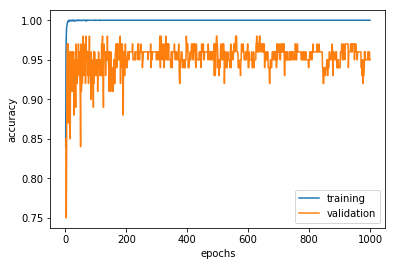

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.datasets import fetch_mldata
import numpy as np
import keras
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop , Nadam

# データを高速かつ効率的に使えるPandasをインポート
import pandas as pd
# 数値計算を効率的に行うNumpyをインポート
import numpy as np
# データを高速かつ効率的に使えるPandasをインポート
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop , Nadam

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

# データタイプをfloat32へ変換
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#x_train /= 255
#x_test /= 255


# ターゲットとなるyを変換
#t_train = np_utils.to_categorical(t_train, 15)
#t_test = np_utils.to_categorical(t_test, 15)

model = Sequential()

# 先に作成したmodelへレイヤーを追加
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(15, activation='softmax'))


# Learnig Processの設定
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

result = model.fit(x_train, t_train, epochs=1000,validation_data=(x_test, t_test))
result.history.keys() # ヒストリデータのラベルを見てみる
loss_and_metrics = model.evaluate(x_test, t_test, batch_size=128)
print(loss_and_metrics)

import matplotlib.pyplot as plt

plt.plot(range(1,1000+1),result.history["acc"],label="training")
plt.plot(range(1,1000+1),result.history["val_acc"],label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()